## Figure 4 Reproduction from Pre-processed Data

This notebook reproduces the main results figure 4 from pre-processed CSV files.

In [1]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from collections import OrderedDict
from scipy import stats
from statsmodels.stats.multitest import multipletests
from matplotlib.ticker import MaxNLocator
from matplotlib.patches import Patch

# --- Matplotlib and Style Settings ---

def apply_matplotlib_settings():
    """Applies a consistent set of matplotlib settings for the plots."""
    settings = {
        "text.usetex": False,
        "mathtext.default": "regular",
        "font.family": "sans-serif",
        "font.sans-serif": ["DejaVu Sans", "Arial", "sans-serif"],
        "font.size": 7,
        "figure.titlesize": 7,
        "legend.fontsize": 7,
        "axes.titlesize": 7,
        "axes.labelsize": 7,
        "xtick.labelsize": 7,
        "ytick.labelsize": 7,
        "axes.spines.top": False,
        "axes.spines.right": False,
        "axes.linewidth": 0.7,
        "xtick.major.width": 0.7,
        "ytick.major.width": 0.7,
        "lines.linewidth": 1.5,
        "lines.markersize": 3,
        "savefig.dpi": 300,
        "figure.dpi": 150,
        "savefig.format": "pdf",
        "savefig.bbox": "tight",
        "savefig.pad_inches": 0.1,
        "svg.fonttype": "none",
        "legend.frameon": False,
        "pdf.fonttype": 42,
    }
    plt.rcParams.update(settings)


def darken_color(hex_color, factor=0.7):
    """Darkens a hex color by a given factor."""
    hex_color = hex_color.lstrip('#')
    rgb = tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))
    darkened_rgb = tuple(int(c * factor) for c in rgb)
    return f"#{darkened_rgb[0]:02x}{darkened_rgb[1]:02x}{darkened_rgb[2]:02x}"


def get_significance_stars(p_value):
    """Converts a p-value to significance stars."""
    if p_value < 0.001: return '***'
    if p_value < 0.01: return '**'
    if p_value < 0.05: return '*'
    return ''

def get_performance_based_order(df, category_col):
    """Calculates the order of categories based on descending median performance."""
    if df is None or df.empty or category_col not in df.columns:
        return []
    median_perf = df.groupby(category_col)['finetuned_roc_auc'].median()
    sorted_categories = median_perf.sort_values(ascending=False).index.tolist()
    print(f"Plot order for '{category_col}': {sorted_categories}")
    return sorted_categories

# --- Statistical Analysis ---

def perform_statistical_tests(data_df, category_col, comparison_type):
    if data_df is None or data_df.empty: return {}
    categories = data_df[category_col].unique()
    test_map = {'config': ('CFT', 'greater'), 'calibration': ('100 Trials', 'less'),'window_size': ('50 ms', 'greater'), 'window_location': ('10 ms', 'greater')}
    if comparison_type not in test_map: return {}
    ref_category, test_direction = test_map[comparison_type]
    if ref_category not in categories: return {}
    ref_data_all = data_df[data_df[category_col] == ref_category]['finetuned_roc_auc'].values
    ref_data_extreme = data_df[data_df[category_col] == ref_category]['finetuned_roc_auc_extreme'].values
    p_values, test_results, valid_categories = [], {}, []
    for cat in categories:
        if cat == ref_category: continue
        cat_data_all = data_df[data_df[category_col] == cat]['finetuned_roc_auc'].values
        cat_data_extreme = data_df[data_df[category_col] == cat]['finetuned_roc_auc_extreme'].values
        if len(cat_data_all) != len(ref_data_all): continue
        valid_categories.append(cat)
        alt = 'greater' if test_direction == 'greater' else 'less'
        _, p_all = stats.ttest_rel(ref_data_all, cat_data_all, alternative=alt)
        _, p_extreme = stats.ttest_rel(ref_data_extreme, cat_data_extreme, alternative=alt)
        p_values.extend([p_all, p_extreme])
        test_results[cat] = {'all': p_all, 'extreme': p_extreme}
    if p_values:
        _, p_corrected, _, _ = multipletests(p_values, method='fdr_bh')
        p_idx = 0
        for cat in valid_categories:
            if cat in test_results:
                test_results[cat]['all_corrected'] = p_corrected[p_idx]; test_results[cat]['extreme_corrected'] = p_corrected[p_idx + 1]
                p_idx += 2
    return test_results

# --- Plotting Functions ---

def create_comparison_violin_plot(ax, data_df, category_col, comparison_type, y_label, x_label_rotation=45):
    if data_df is None or data_df.empty:
        ax.text(0.5, 0.5, 'Data not found', ha='center', va='center'); return
    category_order = get_performance_based_order(data_df, category_col)
    if not category_order: category_order = list(data_df[category_col].unique())
    ref_map = {'config': 'CFT', 'calibration': '100 Trials', 'window_size': '50 ms', 'window_location': '10 ms'}
    ref_category = ref_map.get(comparison_type)
    colors_all = {cat: '#80a687' if cat == ref_category else '#9e9e9e' for cat in category_order}
    colors_extreme = {cat: '#cee1d1' if cat == ref_category else '#e1e1e0' for cat in category_order}
    stat_results = perform_statistical_tests(data_df, category_col, comparison_type)
    df_long = data_df.melt(id_vars=['subject_id', category_col], value_vars=['finetuned_roc_auc', 'finetuned_roc_auc_extreme'], var_name='metric', value_name='roc_auc')
    df_long['variant'] = np.where(df_long['metric'].str.contains('_extreme'), 'Extreme', 'All')
    df_long['cat_variant'] = df_long[category_col].astype(str) + '_' + df_long['variant']
    plot_order = [f'{c}_{v}' for c in category_order for v in ['All', 'Extreme']]
    position_mapping, current_pos = {}, 0
    for c in category_order:
        position_mapping[f'{c}_All'] = current_pos; position_mapping[f'{c}_Extreme'] = current_pos + 0.5; current_pos += 1.8
    palette_dict = {f'{c}_All': colors_all.get(c) for c in category_order}; palette_dict.update({f'{c}_Extreme': colors_extreme.get(c) for c in category_order})
    edge_palette_dict = {k: darken_color(v) for k, v in palette_dict.items()}
    for cat_var in plot_order:
        data_subset = df_long[df_long['cat_variant'] == cat_var]['roc_auc'].dropna()
        if data_subset.empty: continue
        pos, color, edge_color = position_mapping[cat_var], palette_dict.get(cat_var), edge_palette_dict.get(cat_var)
        parts = ax.violinplot(dataset=data_subset, positions=[pos], showextrema=False, widths=0.5, bw_method=0.2)
        for pc in parts['bodies']: pc.set_facecolor(color); pc.set_edgecolor(edge_color); pc.set_linewidth(0.5)
        bp = ax.boxplot(x=data_subset, positions=[pos], vert=True, patch_artist=True, widths=0.2, showfliers=False, whiskerprops={'color': edge_color, 'linewidth': 0.5}, capprops={'color': edge_color, 'linewidth': 0.5}, medianprops={'color': edge_color, 'linewidth': 0.8, 'zorder': 4})
        for patch in bp['boxes']: patch.set_facecolor('w'); patch.set_edgecolor(edge_color); patch.set_linewidth(0.5)
    y_max = max(1.0, data_df['finetuned_roc_auc'].max() + 0.05); ax.set_ylim(0.4, y_max)
    star_y_pos = y_max * 0.98
    for cat_var in plot_order:
        condition, variant = cat_var.rsplit('_', 1); pos = position_mapping[cat_var]
        if condition in stat_results and f"{variant.lower()}_corrected" in stat_results[condition]:
            stars = get_significance_stars(stat_results[condition][f"{variant.lower()}_corrected"])
            if stars: ax.text(pos, star_y_pos, stars, ha='center', va='top', fontsize=5, fontweight='bold')
    tick_positions = [i * 1.8 + 0.25 for i in range(len(category_order))]
    ax.set_xticks(tick_positions); ax.set_xticklabels(category_order, rotation=x_label_rotation, ha="right")
    ax.set_xlabel(''); ax.axhline(0.5, color='gray', linestyle=':', linewidth=1); ax.set_ylabel(y_label)
    ax.legend(handles=[Patch(facecolor='#555555', label='All'), Patch(facecolor='#CCCCCC', label='Extreme')], loc='lower right', handlelength=1)

def create_scatter_comparison_plot(ax, df_merged, label_1, label_2, title):
    """
    Creates a generic scatter plot comparing 'roc_auc_1' and 'roc_auc_2' from a pre-merged DataFrame.
    Also calculates and prints the Pearson correlation.
    """
    if df_merged.empty:
        print(f"Warning: Merging data for '{title}' resulted in an empty DataFrame. Check for common subject_ids.")
        ax.text(0.5, 0.5, 'No common subjects found', ha='center', va='center')
        return
    
    scatter_color, edge_color = '#80a687', darken_color('#80a687')

    ax.scatter(df_merged['roc_auc_2'], df_merged['roc_auc_1'], facecolor=scatter_color, edgecolor=edge_color, alpha=0.8, s=15, linewidth=0.5)

    all_values = pd.concat([df_merged['roc_auc_1'], df_merged['roc_auc_2']])
    lims = [all_values.min() - 0.05, all_values.max() + 0.05]
    ax.set_xlim(lims); ax.set_ylim(lims)

    locator = MaxNLocator(nbins=4, prune='both')
    ticks = locator.tick_values(lims[0], lims[1])
    ax.set_xticks(ticks); ax.set_yticks(ticks)

    ax.plot(lims, lims, color='gray', linestyle=':', linewidth=1, label='Identity')
    ax.axhline(0.5, color='gray', linestyle=':', linewidth=1, alpha=0.7)
    ax.axvline(0.5, color='gray', linestyle=':', linewidth=1, alpha=0.7)

    ax.set_xlabel(label_2); ax.set_ylabel(label_1)
    ax.set_title(title)
    ax.set_aspect('equal', 'box')
    ax.legend(loc='lower right')

    # --- Perform t-test and Pearson correlation ---
    ttest_result = stats.ttest_rel(df_merged['roc_auc_1'], df_merged['roc_auc_2'])
    corr, p_corr = stats.pearsonr(df_merged['roc_auc_1'], df_merged['roc_auc_2'])
    
    print(f"\n--- Scatter Plot Stats for: {title} ---")
    print(f"Paired t-test: p-value = {ttest_result.pvalue:.4f}")
    print(f"Pearson Correlation: r = {corr:.3f}, p-value = {p_corr:.4f}")
    print("----------------------------------------")

    # Add significance stars for t-test
    if ttest_result.pvalue < 0.05:
        stars = get_significance_stars(ttest_result.pvalue)
        ax.text(0.05, 0.95, stars, transform=ax.transAxes, fontsize=8, fontweight='bold', va='top', ha='left')

### Load Data
Load the six CSV files generated by `generate_data.py`.

In [2]:
DATA_DIR = Path('./figure_data_for_reproduction')

try:
    df_config = pd.read_csv(DATA_DIR / 'panel_a_config.csv')
    df_winsize = pd.read_csv(DATA_DIR / 'panel_b_winsize.csv')
    df_winloc = pd.read_csv(DATA_DIR / 'panel_c_winloc.csv')
    df_cal = pd.read_csv(DATA_DIR / 'panel_d_calibration.csv')
    df_scatter_e = pd.read_csv(DATA_DIR / 'panel_e_n45_vs_p60.csv')
    df_scatter_f = pd.read_csv(DATA_DIR / 'panel_f_n45_vs_mep.csv')
    print("All data files loaded successfully.")
except FileNotFoundError as e:
    print(f"Error loading data: {e}")
    print("Please ensure you have run the 'generate_data.py' script first.")

All data files loaded successfully.


### Generate and Save the Figure

Plot order for 'config': ['CFT', 'EA+\nCFT', 'Dec-CFT', 'EA+\nDec-CFT', 'EA', 'Thr-CFT', 'EA+\nThr-CFT']
Plot order for 'window_size': ['50 ms', '100 ms', '200 ms', '300 ms', '400 ms', '500 ms']
Plot order for 'window_location': ['10 ms', '20 ms', '30 ms']
Plot order for 'calibration_trials': ['300 Trials', '200 Trials', '100 Trials']

--- Scatter Plot Stats for: N45 vs. P60 perf. ---
Paired t-test: p-value = 0.0000
Pearson Correlation: r = 0.750, p-value = 0.0000
----------------------------------------

--- Scatter Plot Stats for: N45 vs. MEP perf. ---
Paired t-test: p-value = 0.0000
Pearson Correlation: r = 0.173, p-value = 0.2291
----------------------------------------

✅ Multi-panel figure saved successfully to composite_figure_2x4_layout_final.pdf


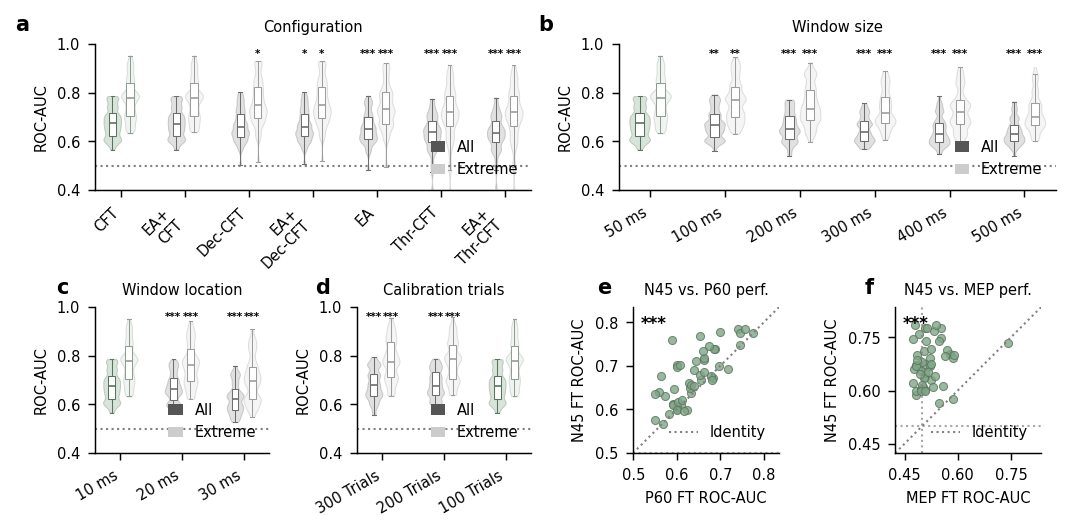

In [3]:
apply_matplotlib_settings()

# --- Create a 2x4 grid layout ---
fig = plt.figure(figsize=(210 / 25.4, 90 / 25.4))
gs = gridspec.GridSpec(2, 4, figure=fig, hspace=0.8, wspace=0.5)

ax_A = fig.add_subplot(gs[0, 0:2])
ax_B = fig.add_subplot(gs[0, 2:4])
ax_C = fig.add_subplot(gs[1, 0])
ax_D = fig.add_subplot(gs[1, 1])
ax_E = fig.add_subplot(gs[1, 2])
ax_F = fig.add_subplot(gs[1, 3])

# --- Panel A: Configuration ---
create_comparison_violin_plot(ax_A, df_config, 'config', 'config', 'ROC-AUC'); 
ax_A.set_title('Configuration')

# --- Panel B: Window size ---
create_comparison_violin_plot(ax_B, df_winsize, 'window_size', 'window_size', 'ROC-AUC', 30)
ax_B.set_title('Window size')

# --- Panel C: Window location ---
create_comparison_violin_plot(ax_C, df_winloc, 'window_location', 'window_location', 'ROC-AUC', 30)
ax_C.set_title('Window location')

# --- Panel D: Calibration trials ---
create_comparison_violin_plot(ax_D, df_cal, 'calibration_trials', 'calibration', 'ROC-AUC', 30)
ax_D.set_title('Calibration trials')

# --- Panel E: N45 vs. P60 perf. ---
create_scatter_comparison_plot(ax=ax_E, df_merged=df_scatter_e, label_1='N45 FT ROC-AUC', label_2='P60 FT ROC-AUC', title='N45 vs. P60 perf.')

# --- Panel F: N45 vs. MEP perf. ---
create_scatter_comparison_plot(ax=ax_F, df_merged=df_scatter_f, label_1='N45 FT ROC-AUC', label_2='MEP FT ROC-AUC', title='N45 vs. MEP perf.')

# --- Update panel labels ---
for ax, label in zip([ax_A, ax_B, ax_C, ax_D, ax_E, ax_F], ['a', 'b', 'c', 'd', 'e', 'f']):
    ax.text(-0.15, 1.2, label, transform=ax.transAxes, fontsize=10, fontweight='bold', va='top', ha='right')

output_filename = "composite_figure_2x4_layout_final.pdf"
plt.savefig(output_filename, bbox_inches='tight')
print(f"\n✅ Multi-panel figure saved successfully to {output_filename}")
plt.show()